In [2]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import euclidean_distances
import SemisupFns as SF
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import MiscFcns as MF
import seaborn as sns
import scipy.stats as ss
import mygene
from __future__ import division
%matplotlib inline

In [70]:
#Getting list of genes which have SNPs according to Greg's GWAS
#cnt = 0 
#GeneNames = []
#MinPval = []
#AvgLogPval = []
#with open("/Users/sumitmukherjee/Documents/DriverPrediction/MiscFiles/outfile2k.txt") as f:
#    for line in f:
#        if cnt <= 1:
#            cnt+=1 
#            continue
            
#        cnt += 1
#        temp = line.split(',')

#        if len(temp)>9:
#            GeneNames += [temp[0]]
#            temp = map(float,temp[9:])
#            MinPval += [min(temp)]
#            AvgLogPval += [np.mean(np.log10(temp))]
        

In [71]:
#Getting list of genes which have SNPs according to IGAP_stage1
cnt = 0 
GeneNames = []
MinPval = []
AvgLogPval = []
with open("/Users/sumitmukherjee/Documents/AMP-AD_Network_Analysis/IGAP_files/IGAP_geneAnalysis.genes.raw") as f:
    for line in f:
        if cnt <= 1:
            cnt+=1 
            continue
#            
        cnt += 1
        temp = line.split(' ')
#
        if len(temp)>9:
            GeneNames += [temp[0]]
            temp = map(float,temp[9:])
            MinPval += [min(temp)]
            AvgLogPval += [np.mean(np.log10(temp))]


In [116]:
Dat = pd.read_csv('./EC2_ConsUnion1_subNet_de_agg_probs.csv')
Dat.head()

,Unnamed: 0,Gene,Y0a,Y0b,Y1a,Y1b,Y3a,Y3b
0,0,ENSG00000000003,1.239686e-09,3.475321e-04,1.969310e-13,4.483267e-11,3.641262e-08,3.377913e-07
1,1,ENSG00000000419,9.556340e-02,1.002533e-01,5.694224e-12,1.257888e-10,2.658082e-09,1.644901e-09
2,2,ENSG00000000457,9.554266e-02,1.002332e-01,9.006047e-13,1.912709e-09,8.923082e-06,3.946321e-05
3,3,ENSG00000000938,2.267269e-13,1.885232e-08,2.108585e-14,4.095635e-11,5.607621e-04,3.240633e-03
4,4,ENSG00000000971,6.603237e-10,3.601890e-05,1.436918e-14,1.244331e-11,2.198939e-04,1.467486e-03


In [141]:
GeneId = Dat['Gene']
Y1 = ((Dat['Y0a']) + (Dat['Y0b']) + (Dat['Y1a']) + (Dat['Y1b']) + (Dat['Y3a']) + (Dat['Y3b']))/6.0

Yd = ((Dat['Y0a']) + (Dat['Y0b']))/2.0
Ya = ((Dat['Y1a']) + (Dat['Y1b']))/2.0
Ys = ((Dat['Y3a']) + (Dat['Y3b']))/2.0

lgcl =(Dat['Y0a']>0.5) + (Dat['Y0b']>0.5) + (Dat['Y1a']>0.5) + (Dat['Y1b']>0.5) + (Dat['Y3a']>0.5) + (Dat['Y3b']>0.5)
#Y1 = ((Dat['Y1a']) + (Dat['Y1b']) + (Dat['Y3a']) + (Dat['Y3b']))/6.0
#lgcl = (Dat['Y1a']>0.5) + (Dat['Y1b']>0.5) + (Dat['Y3a']>0.5) + (Dat['Y3b']>0.5)

#Y1 = ((Dat['Y0a']) + (Dat['Y0b']))/2.0
#lgcl = (Dat['Y0a']>0.5) + (Dat['Y0b']>0.5) 
bla = np.argwhere(lgcl)
bla2 = np.argwhere(np.logical_not(lgcl))
GenePred = list(GeneId[bla[:,0]])
GenePredVal = list(Y1[bla[:,0]])
#Converting to Gene Symbols
GenePred2 = MF.ConvertToSymb(GenePred)
GeneNotPred2 = MF.ConvertToSymb(list(GeneId[bla2[:,0]]))
GeneNotPredVal = list(Y1[bla2[:,0]])

GenePredVal_d = list(Yd[bla[:,0]])
GenePredVal_a = list(Ya[bla[:,0]])
GenePredVal_s = list(Ys[bla[:,0]])

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2433...done.
Finished.
1 input query terms found no hit:
	[u'ENSG00000170647']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12015...done.
Finished.
1 input query terms found dup hits:
	[(u'ENSG00000229425', 2)]
31 input query terms found no hit:
	[u'ENSG00000069712', u'ENSG00000116957', u'ENSG00000179979', u'ENSG00000182109', u'ENSG00000205664',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [142]:
IGAP_genes = pd.DataFrame(data = {'Genes':GeneNames,'Pval':MinPval,'MeanPval':AvgLogPval})

In [143]:
def PredGenesPval(IGAP_genes,GenePred, GenePredVal):
    Int = list(set(GeneNames).intersection(GenePred))
    GenePred = pd.DataFrame({'G':GenePred})

    G = []
    P = []
    Pmean = []
    Y = []

    for i in range(len(Int)):
        In = IGAP_genes['Genes'][IGAP_genes['Genes']==Int[i]].index[0]
        In2 = GenePred['G'][GenePred['G']==Int[i]].index[0]
        G += [IGAP_genes['Genes'][In]]
        P += [IGAP_genes['Pval'][In]]
        Pmean += [IGAP_genes['MeanPval'][In]]
        Y += [GenePredVal[In2]]


    OR = np.log10(np.array(Y)/(1-np.array(Y)))
    PredGenes_pval = pd.DataFrame(data = {'GeneSymb':G,'Pval':P,'MeanPval':Pmean,'Y':Y,'OR':OR})
    return PredGenes_pval

In [144]:
def PredGenesPval3(IGAP_genes,GenePred, GenePredVal_d,GenePredVal_a,GenePredVal_s):
    Int = list(set(GeneNames).intersection(GenePred))
    GenePred = pd.DataFrame({'G':GenePred})

    G = []
    P = []
    Pmean = []
    Yd = []
    Ya = []
    Ys = []

    for i in range(len(Int)):
        In = IGAP_genes['Genes'][IGAP_genes['Genes']==Int[i]].index[0]
        In2 = GenePred['G'][GenePred['G']==Int[i]].index[0]
        G += [IGAP_genes['Genes'][In]]
        P += [IGAP_genes['Pval'][In]]
        Pmean += [IGAP_genes['MeanPval'][In]]
        Yd += [GenePredVal_d[In2]]
        Ya += [GenePredVal_a[In2]]
        Ys += [GenePredVal_s[In2]]


    OR_d = np.log10(np.array(Yd)/(1-np.array(Yd)))
    OR_a = np.log10(np.array(Ya)/(1-np.array(Ya)))
    OR_s = np.log10(np.array(Ys)/(1-np.array(Ys)))
    PredGenes_pval = pd.DataFrame(data = {'GeneSymb':G,'Pval':P,'MeanPval':Pmean,
                                          'Yd':Yd,'OR_d':OR_d,
                                          'Ya':Ya,'OR_a':OR_a,
                                          'Ys':Ys,'OR_s':OR_s})
    return PredGenes_pval

In [145]:
#Getting p-values of predicted genes
PredGenes_pval = PredGenesPval(IGAP_genes,GenePred2, GenePredVal)
NotPredGenes_pval = PredGenesPval(IGAP_genes,GeneNotPred2, GeneNotPredVal)
PredGenes_pval3 = PredGenesPval3(IGAP_genes,GenePred2, GenePredVal_d,GenePredVal_a,GenePredVal_s)
PredGenes_pval3.head()

,GeneSymb,MeanPval,OR_a,OR_d,OR_s,Pval,Ya,Yd,Ys
0,RNF14,-2.487667,-18.189255,-4.830725,1.117052,0.000183,6.467626e-19,0.000015,9.290448e-01
1,HIF3A,-1.965255,0.152842,-0.143488,-5.042771,0.003345,5.870859e-01,0.418145,9.062013e-06
2,NCBP2,-2.179538,-10.130154,0.093436,-0.491754,0.000487,7.410471e-11,0.553579,2.437359e-01
3,RNF13,-3.232988,0.054634,2.165323,-2.722429,0.000055,5.314085e-01,0.993212,1.891248e-03
4,LAPTM5,-2.157617,-2.410783,0.867121,-15.507105,0.000441,3.868419e-03,0.880442,3.110963e-16


In [169]:
PredGenes_pval3['Score'] = (PredGenes_pval3['OR_d']+PredGenes_pval3['OR_a']+PredGenes_pval3['OR_s'])/6.0 - 0.5*PredGenes_pval3['MeanPval']

PG3_sort = PredGenes_pval3.sort_values(by='Score',ascending=False)
PG3_sort.head(25)

,GeneSymb,MeanPval,OR_a,OR_d,OR_s,Pval,Ya,Yd,Ys,Score
123,CD74,-2.117128,3.333940,3.766922,10.537344,0.000585,0.999537,0.999829,1.000000,3.998265
1394,DOCK2,-2.070184,8.884140,2.498906,0.593326,0.000243,1.000000,0.996840,0.796763,3.031154
330,DEF6,-2.077794,4.486922,3.519669,3.872965,0.000310,0.999967,0.999698,0.999866,3.018823
2111,HMOX1,-2.415361,4.685569,3.927575,2.124196,0.000131,0.999979,0.999882,0.992543,2.997237
1982,SLCO2B1,-1.993691,6.219937,-1.003391,6.763535,0.000505,0.999999,0.090266,1.000000,2.993526
1299,TREM2,-2.339654,2.232416,2.170974,5.872964,0.000532,0.994178,0.993300,0.999999,2.882553
995,SLC7A7,-2.051451,5.058421,-2.399971,8.365841,0.000438,0.999991,0.003966,1.000000,2.863107
2053,LAT2,-2.151690,3.343786,3.215519,4.082213,0.000773,0.999547,0.999392,0.999917,2.849431
348,LGALS9,-2.167500,1.647722,5.228962,3.245334,0.003577,0.977990,0.999994,0.999432,2.770753
1752,ITGB2,-1.969687,6.270059,-2.009550,6.369501,0.000412,0.999999,0.009688,1.000000,2.756512


In [170]:
PG3_sort.to_csv('Score_DE_Agg_SubNet.csv')

-0.014295085567562534

In [122]:
#Get t-test value (min)
temp = ss.ttest_ind(np.log10(PredGenes_pval['Pval']),np.log10(NotPredGenes_pval['Pval']))
print temp

Ttest_indResult(statistic=-3.2591442942041016, pvalue=0.0011205942194643349)


In [123]:
#Get t-test value (mean)
temp = ss.ttest_ind((PredGenes_pval['MeanPval']),(NotPredGenes_pval['MeanPval']))
print temp

Ttest_indResult(statistic=-5.599061878620796, pvalue=2.2024108581479414e-08)


In [124]:
PredGenes_pval.head()

,GeneSymb,MeanPval,OR,Pval,Y
0,RNF14,-2.487667,-0.348124,0.000183,0.309687
1,HIF3A,-1.965255,-0.297621,0.003345,0.335080
2,NCBP2,-2.179538,-0.441322,0.000487,0.265772
3,RNF13,-3.232988,0.015354,0.000055,0.508837
4,LAPTM5,-2.157617,-0.378847,0.000441,0.294770


,GeneSymb,MeanPval,OR,Pval,Y,Score
0,RNF14,-2.487667,-10.066816,0.000183,8.574013e-11,4.497926
1,PGM2L1,-1.905722,-0.072870,0.000212,4.581507e-01,15.073817
2,SSFA2,-2.707652,0.454978,0.000145,7.403186e-01,14.799735
3,ZNF708,-2.204050,2.171328,0.000216,9.933049e-01,17.019687
4,CAMK1,-1.885742,-2.742640,0.000765,1.805405e-03,12.424027


In [109]:
PredGenes_pval.to_csv('UnionModelRanking.csv')

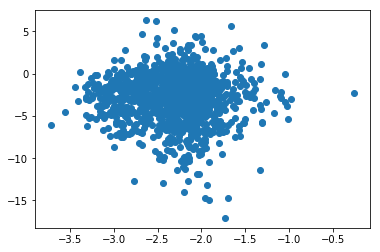

In [110]:
plt.scatter(PredGenes_pval.MeanPval, PredGenes_pval.OR)

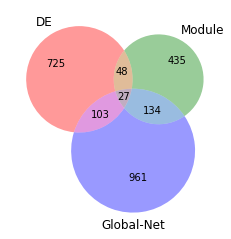

In [96]:
from matplotlib_venn import venn3, venn3_circles
Y = pd.read_excel('./ResponseVec_040318.xlsx')
bla0 = np.argwhere((Dat['Y0a']>0.5) + (Dat['Y0b']>0.5))
bla1 = np.argwhere((Dat['Y1a']>0.5) + (Dat['Y1b']>0.5))
bla3 = np.argwhere((Dat['Y3a']>0.5) + (Dat['Y3b']>0.5))
bla4 = np.argwhere(Y.Y==1)
set1 = set(GeneId[bla0[:,0]])
set2 = set(GeneId[bla1[:,0]])
set3 = set(GeneId[bla3[:,0]])
venn3([set1, set2, set3], ('DE', 'Module', 'Global-Net'))
plt.show()

In [ ]:
PredGenes_pval['Score'] = np.abs(PredGenes_pval['MeanPval'] + PredGenes_pval['OR'] 
                            - min(PredGenes_pval['OR']))
PredGenes_pval.head()

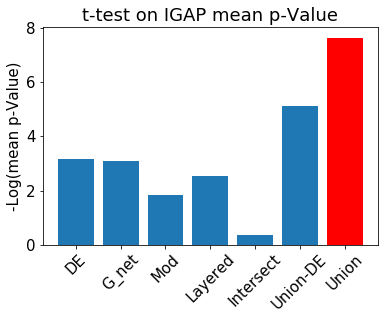

In [186]:
X = -np.log10([7e-4, 7.94e-4, 0.015, 0.003, 0.45, 7.8e-6, 2.2e-8])
plt.rcParams.update({'font.size': 15})
bp = plt.bar(range(len(X)),X)
plt.xticks(range(len(X)),('DE','G_net','Mod','Layered','Intersect','Union-DE','Union'),rotation= 45)
plt.title('t-test on IGAP mean p-Value')
plt.ylabel('-Log(mean p-Value)')
bp[6].set_color('r')